# Wavenet mit Augmentation

- Nach Geron
- Subsample-Länge nun 150 (ca. jeder 10. Datenpunkt)

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, metrics, manifold
from tensorflow import keras
import keras_tuner as kt

import prepare

2025-03-01 08:38:26.095169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-01 08:38:26.095197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-01 08:38:26.096154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 08:38:26.102336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-01 08:38:28.138604: I exter

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER
SUBSAMPLE_LEN = 150

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [6]:
versuche_train_valid, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train_valid.shape, versuche_test.shape

((480, 5), (120, 5))

Subsampling

In [7]:
subsample2 = prepare.Subsample2(SUBSAMPLE_LEN)
subsample2.fit() # dummy

Subsample2(subsample=150)

In [8]:
X_train_valid = subsample2.transform(versuche_train_valid.key, kurven)
festigkeit_train_valid = versuche_train_valid.festigkeit.values
print(X_train_valid.shape, festigkeit_train_valid.shape)
print(X_train_valid.max(axis=(0,1)))

(480, 150, 3) (480,)
[3625.56   625.019    4.15 ]


In [9]:
X_test = subsample2.transform(versuche_test.key, kurven)
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 150, 3)
[3533.99   626.972    3.84 ]


Augmentation

Zum Test ohne Augmentation folgende Zelle auskommentieren. Beobachtung:
- konvergiert nicht immer
- falls doch, deutlich schlechter

In [10]:
X_train_valid, festigkeit_train_valid = prepare.augment_curves(X_train_valid, festigkeit_train_valid, sd_y=0.01)
X_train_valid.shape, festigkeit_train_valid.shape

((5280, 150, 3), (5280,))

In [11]:
X_train, X_valid, festigkeit_train, festigkeit_valid = model_selection.train_test_split(
    X_train_valid, festigkeit_train_valid, test_size=0.15, random_state=23
)
X_train.shape, festigkeit_train.shape, X_valid.shape, festigkeit_valid.shape

((4488, 150, 3), (4488,), (792, 150, 3), (792,))

Skalieren Trainingsdaten, Validation-Daten

In [12]:
tsMaxScale = prepare.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)
X_valid_scaled = tsMaxScale.transform(X_valid)

Skalieren Testdaten

In [13]:
X_test_scaled = tsMaxScale.transform(X_test)

Alle Features verwenden

In [14]:
dims = X_train.shape
#X2_train = X_train_scaled.reshape(-1, dims[1]*dims[2])
#X2_test = X_test_scaled.reshape(-1, dims[1]*dims[2])
#X2_train = X_train_scaled[:,:,0]
#X2_valid = X_valid_scaled[:,:,0]
#X2_test = X_test_scaled[:,:,0]
X2_train = X_train_scaled
X2_valid = X_valid_scaled
X2_test = X_test_scaled
X2_train.shape

(4488, 150, 3)

Wavenet nach Geron

Learning rate:
- zunächst klein zum Einschwingen (aber auch nicht zu klein, sonst startet kein Lernen)
- dann relativ groß
- später stufenweise verkleinern

In [15]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=X2_train.shape[1:]))
for rate in (1, 2, 4, 8, 16, 32, 64) * 2:
    model.add(keras.layers.Conv1D(
        filters=64, kernel_size=2, padding='causal',
        kernel_initializer='he_normal',
        activation='relu',
        dilation_rate=rate
    ))
model.add(keras.layers.Conv1D(
    filters=32, kernel_size=1,
    kernel_initializer='he_normal',
))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, kernel_initializer='he_normal', activation='relu'))
model.add(keras.layers.Lambda(lambda x: x*2000))

ls = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5, 25, 40, 70],
    values=[1e-5, 5e-4, 1e-4, 1e-5, 2e-6],
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=ls),
    loss=keras.losses.MeanSquaredError(),
)
model.summary()
           

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 150, 64)           448       
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 64)           8256      
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 64)           8256      
                                                                 
 conv1d_3 (Conv1D)           (None, 150, 64)           8256      
                                                                 
 conv1d_4 (Conv1D)           (None, 150, 64)           8256      
                                                                 
 conv1d_5 (Conv1D)           (None, 150, 64)           8256      
                                                                 
 conv1d_6 (Conv1D)           (None, 150, 64)           8

In [16]:
# uncomment to disable gpu
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

hist = model.fit(X2_train, festigkeit_train, epochs=100, batch_size=16,
    validation_data=(X2_valid, festigkeit_valid),
    callbacks=[early_stopping]
)
y_pred_valid = model.predict(X2_valid)
metrics.mean_squared_error(y_pred_valid, festigkeit_valid)


Epoch 1/100


2025-03-01 08:38:44.326925: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-01 08:38:45.681071: I external/local_xla/xla/service/service.cc:168] XLA service 0x759c25bf9200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-01 08:38:45.681099: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-03-01 08:38:45.687350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740814725.770941   41550 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 [==============================] - 13s 20ms/step - loss: 2821670.0000 - val_loss: 882837.8125
Epoch 2/100
281/281 [==============================] - 2s 8ms/step - loss: 695250.1250 - val_loss: 593172.0000
Epoch 3/100
281/281 [==============================] - 2s 9ms/step - loss: 450141.7812 - val_loss: 368114.6250
Epoch 4/100
281/281 [==============================] - 2s 9ms/step - loss: 278175.5625 - val_loss: 225473.6094
Epoch 5/100
281/281 [==============================] - 2s 9ms/step - loss: 171666.1562 - val_loss: 137912.5625
Epoch 6/100
281/281 [==============================] - 2s 8ms/step - loss: 109908.2812 - val_loss: 92654.1406
Epoch 7/100
281/281 [==============================] - 2s 9ms/step - loss: 77424.7031 - val_loss: 68669.9375
Epoch 8/100
281/281 [==============================] - 2s 9ms/step - loss: 59607.3633 - val_loss: 53355.8594
Epoch 9/100
281/281 [==============================] - 2s 9ms/step - loss: 48599.8594 - val_loss: 44724.8555
Epoch 10/100
281/

18074.20069701575

<Axes: >

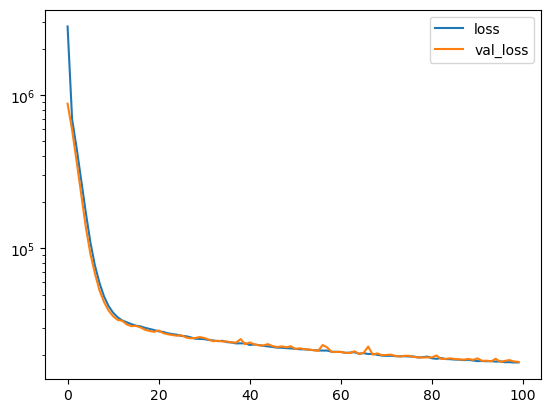

In [17]:
pd.DataFrame(hist.history).plot(logy=True)

Vorhersage Trainingsdaten

141/141 [==============================] - 0s 3ms/step


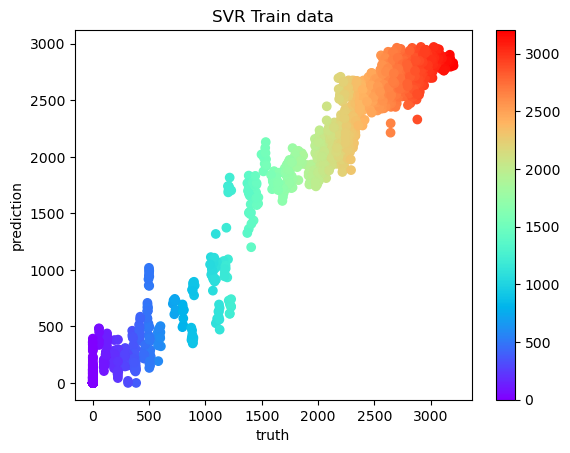

In [18]:
y_pred_train = model.predict(X2_train)#*SCALE_FEST
plt.scatter(festigkeit_train, y_pred_train, c=festigkeit_train, cmap='rainbow')
plt.title('SVR Train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar()
plt.savefig('ann1_train.png')

25/25 [==============================] - 0s 3ms/step


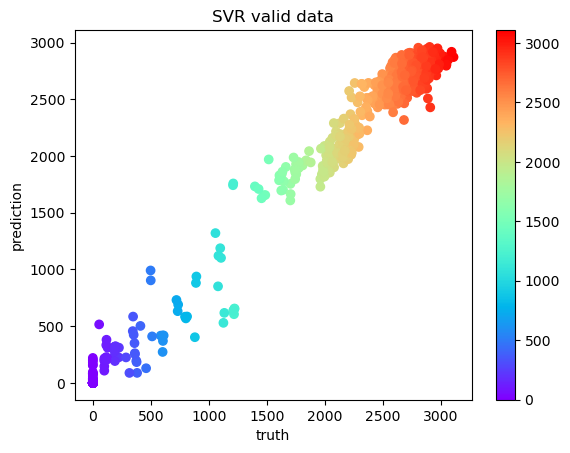

In [19]:
y_pred_valid = model.predict(X2_valid)#*SCALE_FEST
plt.scatter(festigkeit_valid, y_pred_valid, c=festigkeit_valid, cmap='rainbow')
plt.title('SVR valid data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar()
plt.savefig('ann1_valid.png')

Vorhersage Testdaten

4/4 [==============================] - 0s 3ms/step


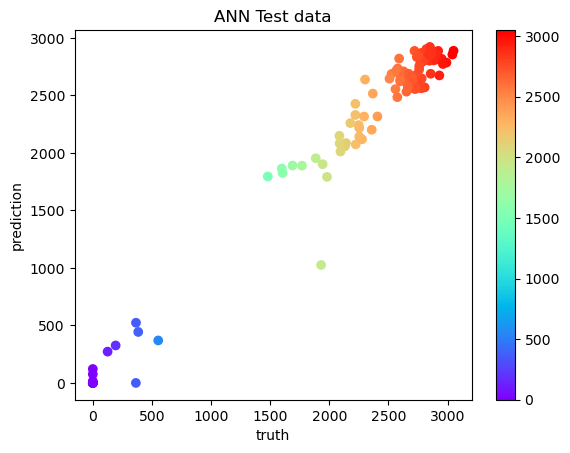

In [20]:
y_pred_test = model.predict(X2_test)#*SCALE_FEST
plt.scatter(festigkeit_test, y_pred_test, c=festigkeit_test, cmap='rainbow')
#plt.plot([0, 3000], [0,3000], "k:")
plt.title('ANN Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar()
plt.savefig('ann1_test.png')

In [21]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")


MSE: train  17617.8, test:  21044.0
RMSE: train    132.7 test:    145.1
MAE: train     96.3, test:     97.1
